In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

import yfinance as yf

import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Load Data from Yahoo Finance

In [2]:
df = yf.download("SPY BTC-USD", start="2015-01-02", end="2021-06-30")['Adj Close']

[*********************100%***********************]  2 of 2 completed


## Modify data to drop NaN and convert to percentage

In [3]:
returns = df.dropna(axis=0)
returns = returns.pct_change()
returns

,BTC-USD,SPY
Date,,
2015-01-02,NaN,NaN
2015-01-05,-0.128743,-0.018060
2015-01-06,0.042682,-0.009419
2015-01-07,0.028471,0.012461
2015-01-08,-0.037331,0.017745
...,...,...
2021-06-23,0.037451,-0.001205
2021-06-24,0.027857,0.005916
2021-06-25,-0.087260,0.003552


# Build Dataframe for Metrics

### Construct an empty dataframe with pd.DataFrame(), set the columns of the new frame to equal the columns of the "returns" dataframe

In [4]:
metrics = pd.DataFrame(columns=returns.columns)

#### Note that these are total returns, not excess returns. Sharpe ratio is defined as the mean over vol of excess returns, but it is often extended to total returns when comparing two securities, as the subtraction of the risk-free rate makes little difference to the comparison

In [5]:
metrics.loc['mean'] = returns.mean()
metrics.loc['vol'] = returns.std()
metrics.loc['sharpe'] = returns.mean() / returns.std()

metrics.loc['mean'] *= 252
metrics.loc['vol'] *= np.sqrt(252)
metrics.loc['sharpe'] *= np.sqrt(252)

metrics

,BTC-USD,SPY
mean,1.011675,0.148695
vol,0.743659,0.180234
sharpe,1.360402,0.825015


## Plot of SPY and BTC in Cumulative Returns

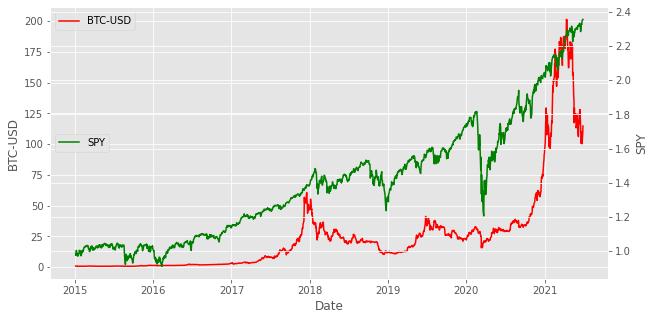

In [6]:
fig, ax1 = plt.subplots(figsize=(10,5))

ax1.set_xlabel('Date')
ax1.set_ylabel('BTC-USD')
ax1.plot(returns.index, (1+returns['BTC-USD']).cumprod(), color='r', label='BTC-USD')

ax2 = ax1.twinx()  
ax2.set_ylabel('SPY')  
ax2.plot(returns.index, (1+returns['SPY']).cumprod(), color='g', label='SPY')

ax1.legend(loc='upper left')
ax2.legend(loc='center left')
plt.show()

## Maximum Drawdown

In [7]:
cum_returns = (1 + returns).cumprod()
rolling_max = cum_returns.cummax()
drawdown = (cum_returns - rolling_max) / rolling_max

metrics.loc['max drawdown'] = drawdown.min()

<AxesSubplot:xlabel='Date'>

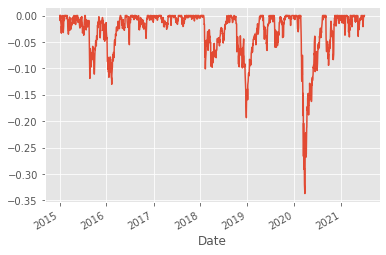

In [8]:
drawdown['SPY'].plot()

<AxesSubplot:xlabel='Date'>

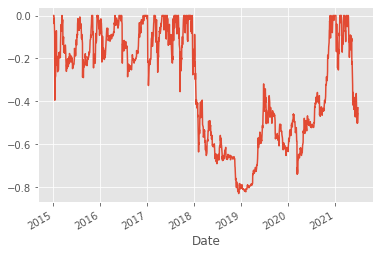

In [9]:
drawdown['BTC-USD'].plot()

## OLS Regression of BTC on SPY

In [10]:
y = returns['BTC-USD']
# use .add_constant on the X data to include an intercept, (to include an alpha)
X = sm.add_constant(returns['SPY'])
results = sm.OLS(y,X,missing='drop').fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                BTC-USD   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     34.30
Date:                Tue, 29 Jun 2021   Prob (F-statistic):           5.69e-09
Time:                        11:14:46   Log-Likelihood:                 2698.8
No. Observations:                1633   AIC:                            -5394.
Df Residuals:                    1631   BIC:                            -5383.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.001      3.189      0.0

## Information Ratio and Treynor Ratio

SPY has a market beta of 1, since we are using SPY as "the market". We could regress SPY on SPY, and we'd get alpha=0, beta=1, and residuals=0. Thus, Info ratio is undefined, Treynor ratio is simply the mean return.

In [11]:
mkt_beta = results.params['SPY']
metrics.loc['mkt beta'] = [mkt_beta, 1]

In [12]:
info_ratio = results.params['const'] / results.resid.std()
# annualize by sqrt(252)
metrics.loc['info ratio'] = [info_ratio * np.sqrt(252), None]

In [13]:
treynor_ratio = y.mean() / mkt_beta
# annualize by 252
metrics.loc['treynor ratio'] = [treynor_ratio * 252, returns['SPY'].mean() * 252]

In [14]:
metrics

,BTC-USD,SPY
mean,1.011675,0.148695
vol,0.743659,0.180234
sharpe,1.360402,0.825015
max drawdown,-0.830363,-0.337173
mkt beta,0.592185,1.000000
info ratio,1.254987,NaN
treynor ratio,1.708378,0.148695
